<a href="https://colab.research.google.com/github/kareemullah123456789/9ambatch/blob/master/ML_Model_classification_usig_MLLib22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=02183c56d811fd395bbb6d74e8ad398ebc14a06220a7d1daf48c96a2a0b4a211
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


In [ ]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



For each categorical column, this line creates a StringIndexer object. StringIndexer is used to convert categorical strings into numerical indices. The inputCol parameter specifies the input column to index, and the outputCol parameter specifies the name of the indexed column.

his line creates a OneHotEncoder object. OneHotEncoder converts indexed categorical variables into binary vectors. The inputCols parameter specifies the input columns to encode (in this case, it's the output column of the StringIndexer), and the outputCols parameter specifies the names of the encoded columns

appends both the StringIndexer and OneHotEncoder objects to the stages list.

creates a StringIndexer object for the label column ('deposit' column in this case). This is similar to what was done for categorical columns but for the label column.

appends the StringIndexer object for the label column to the stages list

 list called numericCols which contains the names of columns in your dataset that are numeric and do not need preprocessing.

In [ ]:
creates a list called assemblerInputs which contains the names of all the columns (both encoded categorical columns and numeric columns) that will be assembled into the feature vector.


line creates a VectorAssembler object. VectorAssembler is used to assemble the feature vector from individual columns. The inputCols parameter specifies the input columns to assemble, and the outputCol parameter specifies the name of the output column containing the assembled feature vector.

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']a
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
stages

[StringIndexer_149b1948c842,
 OneHotEncoder_c7ad75ecb38f,
 StringIndexer_cc4040105928,
 OneHotEncoder_aee1cfe16c66,
 StringIndexer_ce02c08f4def,
 OneHotEncoder_122046aaf6f4,
 StringIndexer_ab38b6c7b5c7,
 OneHotEncoder_2836cfd61b3f,
 StringIndexer_84778cc40273,
 OneHotEncoder_f112e0352f88,
 StringIndexer_57cca29d486b,
 OneHotEncoder_c8a8ab6cd719,
 StringIndexer_03016a51a9f4,
 OneHotEncoder_7b4cea3e3c6a,
 StringIndexer_90ea9504641d,
 OneHotEncoder_b4076f08ed8e,
 StringIndexer_4eaa2430d64c,
 VectorAssembler_493e97ab68b5]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

In [ ]:
df.show(2)

+-----+--------------------+---+------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|label|            features|age|   job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|  1.0|(30,[3,11,13,16,1...| 59|admin.|married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[3,11,13,16,1...| 56|admin.|married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0| unknown|    yes|
+-----+--------------------+---+------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
only showing top 2 rows



In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# beta = np.sort(lrModel.coefficients)
# plt.plot(beta)
# plt.ylabel('Beta Coefficients')
# plt.show()

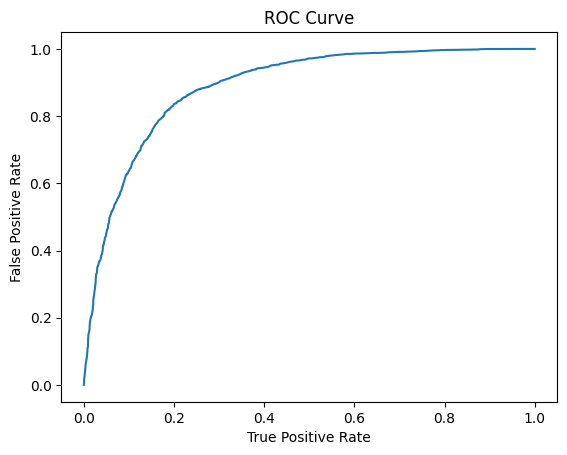

Training set areaUnderROC: 0.8877385690600346


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
predictions = lrModel.transform(test)
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
predictions.show()

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|label|            features|age|       job|marital|education|default|balance|housing|loan|  contact|duration|campaign|pdays|previous|poutcome|deposit|       rawPrediction|         probability|prediction|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...| 33|management|married|secondary|     no|    333|     no|  no| cellular|      80|       6|   -1|       0| unknown|     no|[1.93084854518128...|[0.87334331124860...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 49|management|married|secondary|     no|   1601|     no|  no| cellular|      47|       5|   -1|       0| unknown|     no|[1.92783695472097...|[0.8730098101

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[16.1053947954612...|       0.0|[0.80526973977306...|
| 49|management|  0.0|[16.0096358644511...|       0.0|[0.80048179322255...|
| 52|management|  0.0|[6.08278303564291...|       1.0|[0.30413915178214...|
| 53|management|  0.0|[13.6370640052584...|       0.0|[0.68185320026292...|
| 58|management|  0.0|[16.0711097177897...|       0.0|[0.80355548588948...|
| 32|management|  0.0|[14.9248209644118...|       0.0|[0.74624104822059...|
| 57|management|  0.0|[13.5744920336565...|       0.0|[0.67872460168282...|
| 52|management|  0.0|[16.8838025319322...|       0.0|[0.84419012659661...|
| 46|management|  0.0|[15.4877041487165...|       0.0|[0.77438520743582...|
| 31|management|  0.0|[15.0910635982023...|       0.0|[0.75455317991011...|
+---+-------

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.880654011404673
